In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim

## Saccades

We have inputs to an Artificial Neural Network like these:

In [2]:
input = torch.tensor([
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [1, 1, 1, 1, 1]
], dtype=torch.float)

They represent some geometric objects. In this case it's a line.

The receptive field in our ANN will be bigger than this input. Every input is randomly moved.

So next, we take the input and create K=5 displacements (moving the original tensor in receptive field by (x,y) offset).

In [3]:
K = 5
N = 15

In [4]:
def create_displaced_tensors(tensor, K, receptive_field_size=(15, 15)):
    """
    Creates K displacements of the input tensor by moving it within a larger receptive field.
    
    Parameters:
        tensor (torch.Tensor): The original input tensor of shape (5, 5).
        K (int): The number of displacements to create.
        receptive_field_size (tuple): The dimensions of the receptive field (height, width).
        
    Returns:
        batch of tensors: A tensor of K tensors with the original tensor displaced within the receptive field.
    """
    
    # Create a larger tensor filled with zeros (the receptive field)
    receptive_field_h, receptive_field_w = receptive_field_size
    displaced_tensors = torch.zeros(K, receptive_field_h, receptive_field_w, dtype=tensor.dtype)
    
    # Calculate padding size based on the receptive field dimensions
    input_h, input_w = tensor.shape
    padding_h = receptive_field_h - input_h
    padding_w = receptive_field_w - input_w
    
    for i in range(K):
        # Randomly choose top-left corner for placing the input tensor within the receptive field
        max_x_offset = padding_h
        max_y_offset = padding_w
        x_offset = random.randint(0, max_x_offset)
        y_offset = random.randint(0, max_y_offset)
        
        # Place the input tensor within the receptive field at the chosen offset
        displaced_tensors[i, x_offset:x_offset + input_h, y_offset:y_offset + input_w] = tensor

    return displaced_tensors

input_saccades = create_displaced_tensors(input,
                                          K=K,
                                          receptive_field_size=(N, N))

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

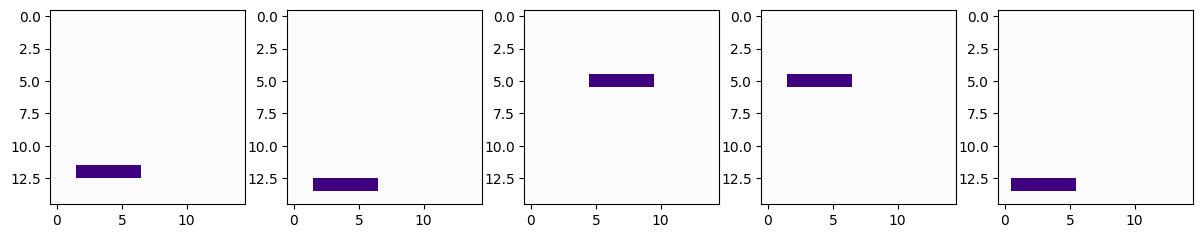

In [6]:
fig, axs = plt.subplots(1, K, figsize=(12, 4))
for i in range(K):
  axs[i].imshow(input_saccades[i].detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()


## Hierarchical network

Purpose of the first step is to make transformations absolutely unlinked from the coordinates. We will be building a hierarchical network that will generalize the concept.

In this configuration we cannot use any output tensors or labels and therefore an error function cannot be used for backpropagation in weight adjustment. 

So, how to make a hierarchical network (not CNN) and group these different representation of lines into one latent feature activated on the last layer?

Adjust weights for each connection using Oja’s rule:
   
$
\Delta w_{ij} = \eta \cdot y_i (x_j - y_i \cdot w_{ij})
$

where:

- $w_{ij}$ is the weight between neuron $j$ in the previous layer and neuron $i$ in the current layer.
- $\eta$ is the learning rate.
- $x_j$ is the activation from the previous layer.
- $y_i$ is the activation of the current neuron after applying the current weights.

Now test this trained network on another type of input

In [7]:
new_input = torch.tensor([
  [1, 1, 1, 1, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1],
  [1, 1, 1, 1, 1]
], dtype=torch.float)
test_set = create_displaced_tensors(new_input,
                                    K=K,
                                    receptive_field_size=(N, N))

## Hierarchical network with feedback

In [8]:
M = N*N

dim_list = [
    [M, 36],
    [36, 16],
    [16, 8],
    [8, 16],
    [16+M, 36],
    [36+M, M],
]

class HierarchicalWithFeedback2(nn.Module):
    def __init__(self, 
                 dim_list,
                 learning_rate=0.01):
        super(HierarchicalWithFeedback2, self).__init__()

        self.layers = nn.ModuleList([nn.Linear(in_dim, out_dim) for in_dim, out_dim in dim_list])
        self.forward_layers = self.layers[:3]
        self.inverse_layers = self.layers[3:]
        self.eta = learning_rate
        self.tau = 0.4

    def forward(self, x):
        x = x.flatten()
        activations = [x]
        for layer in self.forward_layers:
            x = torch.relu(layer(x))
            activations.append(x)
        return activations
    
    def forward_back(self, x, z):
        # x = activations[0] # original input
        # z = forward_activations[-1] # latent space
        back_activations = [z]
        for i in range(len(self.inverse_layers)):
            layer = self.inverse_layers[i]
            if i > 0:
                z = torch.cat([x, z], dim=0)
            z = layer(z)
            z = torch.relu(z)
            back_activations.append(z)
        return back_activations

    def oja_update(self, activations):
        for i in range(len(activations) - 1):
            layer = self.forward_layers[i]
            weight = layer.weight.data
            
            prev_layer_x = activations[i]
            curr_layer_y = activations[i + 1].unsqueeze(0).T

            weight += self.eta * curr_layer_y * (prev_layer_x - curr_layer_y * weight)
    
    def oja_update_back(self, activations, forward_activations):
        x = forward_activations[0]
        for i in range(len(activations) - 1):
            layer = self.inverse_layers[i]
            weight = layer.weight.data
            
            z = activations[i]
            if i > 0:
                z = torch.cat([x, z], dim=0)
            prev_layer_x = z
            if i + 1 == len(activations) - 1:
                curr_layer_y = (forward_activations[0]).unsqueeze(0).T
            else:
                curr_layer_y = (activations[i + 1]).unsqueeze(0).T
            weight += self.eta * curr_layer_y * (prev_layer_x - curr_layer_y * weight)

In [9]:
model = HierarchicalWithFeedback2(dim_list)

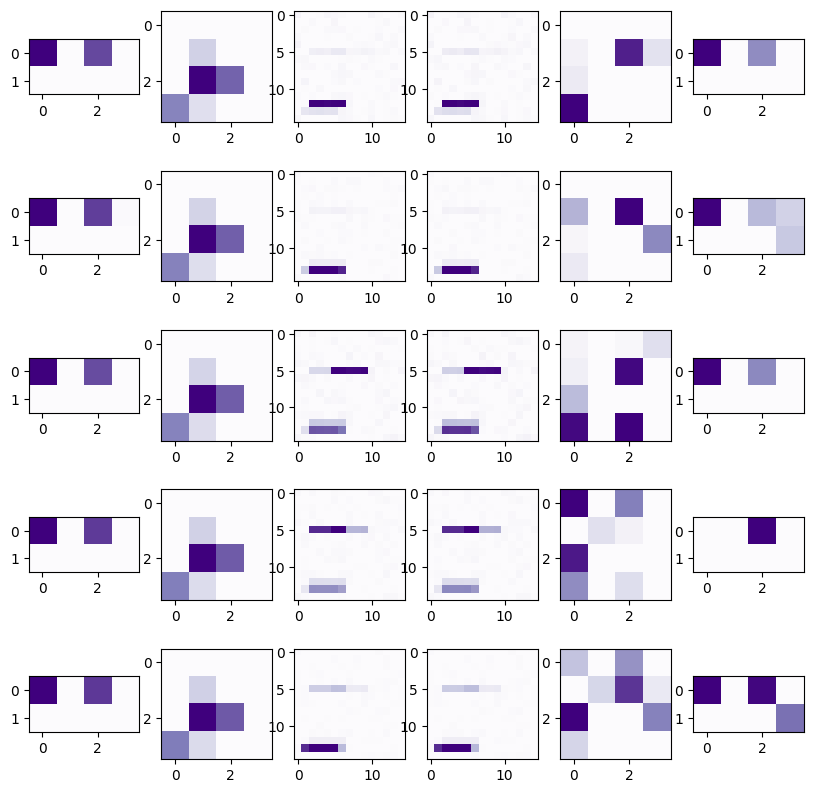

In [12]:
model.eta = 0.5
model.tau = 0.4

fig, axs = plt.subplots(K, 6, figsize=(10, 10))

for i in range(K):
    x = input_saccades[i]
    y = model(x)
    z = model.forward_back(y[0], y[-1])
    model.oja_update_back(z, y)
    zz = model.forward_back(y[0], y[-1])
    
    error = zz[3] - y[0]
    correction = model(error)
    
    axs[i,0].imshow(zz[0].view(2,-1).detach().numpy(), cmap=cm.Purples)
    axs[i,1].imshow(zz[1].view(4,4).detach().numpy(), cmap=cm.Purples)
    axs[i,2].imshow(zz[3].view(15,15).detach().numpy(), cmap=cm.Purples)
    axs[i,3].imshow(error.view(15,15).detach().numpy(), cmap=cm.Purples)
    axs[i,4].imshow(correction[2].view(4,4).detach().numpy(), cmap=cm.Purples)
    axs[i,5].imshow(correction[3].view(2,-1).detach().numpy(), cmap=cm.Purples)

plt.show()

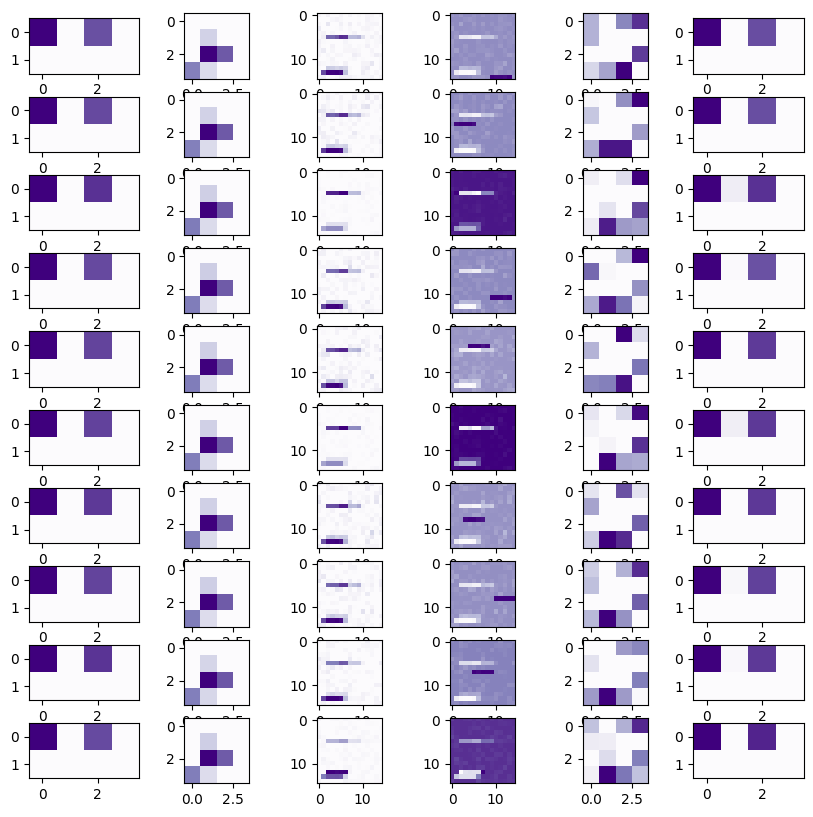

In [13]:
L = 10
test_saccades = create_displaced_tensors(input, K=L, receptive_field_size=(N, N))
fig, axs = plt.subplots(L, 6, figsize=(10, 10))
# x = test_set[0]

for i in range(L):
    x = test_saccades[i]
    # y0 = torch.zeros_like(input_saccades[k]).flatten()
    y = model(x)
    aa = model.forward_back(y[0], y[-1])

    error = y[0] - aa[3]
    correction = model(error)
    
    axs[i,0].imshow(aa[0].view(2,-1).detach().numpy(), cmap=cm.Purples)
    axs[i,1].imshow(aa[1].view(4,4).detach().numpy(), cmap=cm.Purples)
    axs[i,2].imshow(aa[3].view(15,15).detach().numpy(), cmap=cm.Purples)
    axs[i,3].imshow(error.view(15,15).detach().numpy(), cmap=cm.Purples)
    axs[i,4].imshow(correction[2].view(4,4).detach().numpy(), cmap=cm.Purples)
    axs[i,5].imshow(correction[3].view(2,-1).detach().numpy(), cmap=cm.Purples)

plt.show()

In Oja’s learning rule, weights tend to reinforce only excitatory (positive) connections because the rule inherently amplifies positive activations and drives down negative values. 
However, in a biologically inspired network, it's important to include both excitatory (positive) and inhibitory (negative) connections

## Two matrices

Split the weights into two matrices: one exclusively for excitatory connections (positive weights) and another for inhibitory connections (negative weights)

In [27]:
class ExcitatoryAndInhibitorySplit(nn.Module):
    def __init__(self, 
                 dim_list,
                 learning_rate=0.01):
        super(ExcitatoryAndInhibitorySplit, self).__init__()

        self.layers = nn.ModuleList([nn.Linear(in_dim, out_dim) for in_dim, out_dim in dim_list])
        self.w_pos = []
        self.w_neg = []
        for layer in self.layers:
            self.w_pos.append(torch.randn_like(layer.weight))
            self.w_neg.append(torch.randn_like(layer.weight))
        self.forward_layers = self.layers[:3]
        self.inverse_layers = self.layers[3:]
        self.eta = learning_rate
        self.tau = 0.4

    def forward(self, x):
        x = x.flatten()
        activations = [x]
        for i in range(len(self.forward_layers)):
            layer = self.forward_layers[i]
            x = torch.matmul(self.w_pos[i] + self.w_neg[i], x)
            x = torch.relu(x)
            activations.append(x)
        return activations
    
    def forward_back(self, x, z):
        # x = activations[0] # original input
        # z = forward_activations[-1] # latent space
        back_activations = [z]
        for i in range(len(self.inverse_layers)):
            layer = self.inverse_layers[i]
            if i > 0:
                z = torch.cat([x, z], dim=0)
            z = layer(z)
            z = torch.relu(z)
            back_activations.append(z)
        return back_activations

    def oja_update(self, activations):
        for i in range(len(activations) - 1):
            
            prev_layer_x = activations[i]
            curr_layer_y = activations[i + 1].unsqueeze(0).T

            self.w_pos[i] += self.eta * curr_layer_y * (prev_layer_x - curr_layer_y * self.w_pos[i])
            self.w_neg[i] -= self.eta * curr_layer_y * (prev_layer_x + curr_layer_y * self.w_neg[i])
    
    def oja_update_back(self, activations, forward_activations):
        x = forward_activations[0]
        for i in range(len(activations) - 1):
            layer = self.inverse_layers[i]
            weight = layer.weight.data
            
            z = activations[i]
            if i > 0:
                z = torch.cat([x, z], dim=0)
            prev_layer_x = z
            if i + 1 == len(activations) - 1:
                curr_layer_y = (forward_activations[0]).unsqueeze(0).T
            else:
                curr_layer_y = (activations[i + 1]).unsqueeze(0).T
            weight += self.eta * curr_layer_y * (prev_layer_x - curr_layer_y * weight)

In [28]:
model = ExcitatoryAndInhibitorySplit(dim_list)

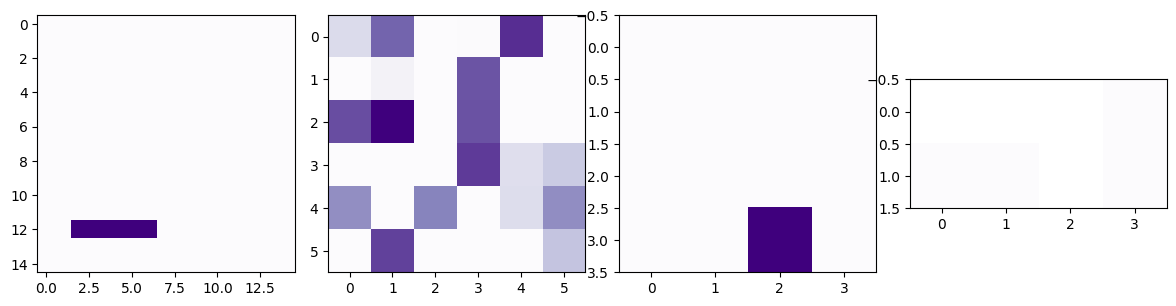

In [29]:
for i in range(K):
    activations = model(input_saccades[i])
    model.oja_update(activations)

z = input_saccades[0]
per_layer_data = model(z)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(per_layer_data[0].view(15,15).detach().numpy(), cmap=cm.Purples)
axs[1].imshow(per_layer_data[1].view(6,6).detach().numpy(), cmap=cm.Purples)
axs[2].imshow(per_layer_data[2].view(4,4).detach().numpy(), cmap=cm.Purples)
axs[3].imshow(per_layer_data[3].view(2,-1).detach().numpy(), cmap=cm.Purples)

plt.tight_layout()
plt.show()

In [34]:
model.w_neg[0]

tensor([[-0.2732, -1.5539,  0.4341,  ..., -0.1727, -0.8519, -0.8841],
        [-0.5203,  0.8190,  0.3180,  ...,  1.1960, -0.1699, -0.1686],
        [ 0.3941,  0.1303,  0.5482,  ...,  0.8451,  0.6140, -0.6503],
        ...,
        [ 0.4061,  0.7200, -0.2843,  ...,  0.6282, -0.2567,  0.1323],
        [ 0.4514, -0.3621, -0.1578,  ...,  1.0169, -0.6470, -0.4041],
        [ 0.2554,  0.2463,  0.0814,  ..., -1.4150, -0.5673,  0.0508]])